# Load Camera Calibration
Load the calibration data of the cameras

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from trajektstereovision.pylon_camera import StereoCalibration

mm_to_ft = 3.28/1000
ftps_to_mph = 0.681818
ft_to_in = 12

leader_cam_serial = "40234821"
follower_cam_serial = "40234823"


show_debug_images = True

stereo_cal = StereoCalibration.load(
    f"camera_files/L{leader_cam_serial},F{follower_cam_serial}/stereo_calibration.npz")

# Collect Data
iterates through each video (6 total) and creates a dictionary of each video and its meta data

In [21]:
img_data_path = "videos/Mar13_ImgData/"
files = os.listdir(img_data_path)
leaders = [f for f in files if f.startswith("L_imgs_")]
leaders.sort()
followers = [f for f in files if f.startswith("F_imgs_")]
followers.sort()


img_data = []
for lead_fname, follow_fname in zip(leaders, followers):
    # Metadata
    capture_global_t = lead_fname.split("_")[-1].split(".npy")[0]
    assert capture_global_t == follow_fname.split("_")[-1].split(".npy")[0], "Lead/follow img data mismatch!"
    pitch_count = lead_fname.split("_PC_")[-1].split("_")[0]
    assert pitch_count == follow_fname.split("_PC_")[-1].split("_")[0], "Lead/follow img data mismatch!"
    fps = 120

    # Video data
    leader_imgs = np.load(os.path.join(img_data_path, lead_fname))
    follower_imgs = np.load(os.path.join(img_data_path, follow_fname))
    n_imgs = min(len(leader_imgs), len(follower_imgs))
    leader_imgs = leader_imgs[:n_imgs]
    follower_imgs = follower_imgs[:n_imgs]
    local_ts = np.arange(n_imgs) / fps

    img_data.append(
        {
            "leader": leader_imgs,
            "follower": follower_imgs,
            "local_ts": local_ts,
            "capture_global_t": capture_global_t,
            "pitch_count": pitch_count,
        }
    )

img_data.sort(key=lambda x: x["capture_global_t"])

# Check Rectification

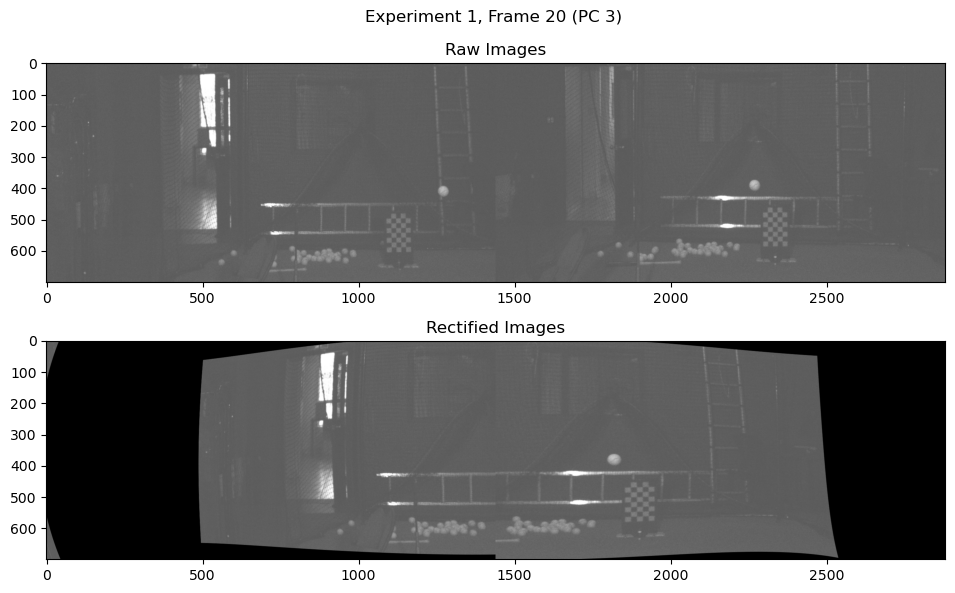

In [22]:
experiment_idx = 1
test_frame_idx = 20

experiment = img_data[experiment_idx]
leader_imgs = experiment["leader"]
follower_imgs = experiment["follower"]
local_ts = experiment["local_ts"]

test_img_pair_raw = [
    leader_imgs[test_frame_idx],
    follower_imgs[test_frame_idx],
]
test_img_pair_rect = stereo_cal.rectify(
    test_img_pair_raw[0], test_img_pair_raw[1]
)

if show_debug_images:
    # Plot Raw Images
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(2, 1, 1)
    ax.imshow(np.hstack(test_img_pair_raw))
    ax.set_title(f"Raw Images")
    ax = fig.add_subplot(2, 1, 2)
    ax.imshow(np.hstack(test_img_pair_rect))
    ax.set_title("Rectified Images")
    fig.suptitle(f"Experiment {experiment_idx}, Frame {test_frame_idx} (PC {experiment['pitch_count']})")
    plt.tight_layout()
    plt.show()





# Create Disparity map

(700, 1440)
(700, 1440)


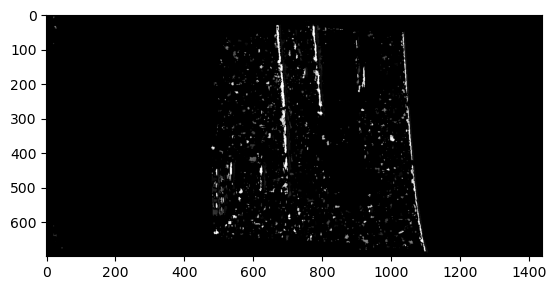

In [23]:
imgL = cv2.cvtColor(test_img_pair_rect[0], cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(test_img_pair_rect[1], cv2.COLOR_BGR2GRAY)

# Ensure the images are 8-bit (values between 0 and 255)
imgL = cv2.normalize(imgL, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
imgR = cv2.normalize(imgR, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
print(imgL.shape)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)

disparity = stereo.compute(imgL, imgR)
print(disparity.shape)

plt.imshow(disparity, 'gray')
plt.show()




# Calculate the Depth

In [24]:
baseline = stereo_cal.baseline
print(f"Baseline: {baseline} mm")
f = stereo_cal.rectification_result.P1[0][0]
print(f"Focal Length: {f} px")

disparity_map = disparity.astype(float)  # Convert disparity map to float

# Get the center pixel coordinates
height, width = disparity_map.shape
center_x = width // 2
center_y = height // 2

# Get the disparity value at the center pixel
center_disparity = disparity_map[center_y, center_x]

# Calculate the depth
depth = baseline * f / center_disparity


print(f"Depth: {depth*mm_to_ft} ft") # not correct at all


Baseline: 2634.685263175219 mm
Focal Length: 4347.054297306609 px
Depth: -2347.889578543927 ft
